**Executed:** Mon Feb 20 17:44:27 2017

**Duration:** 8 seconds.

In [1]:
# default values of file paths, assuming quantum_fog is working dir
in_bif = 'examples_cbnets/earthquake.bif'
in_dot = 'examples_cbnets/earthquake.dot'
in_csv = 'learning/training_data_c/earthquake.csv'

In [2]:
# Cell inserted during automated execution.
in_bif = 'examples_cbnets/asia.bif'
in_dot = 'examples_cbnets/asia.dot'
in_csv = 'learning/training_data_c/tempo.csv'

In [3]:
learned_dot = 'examples_cbnets/tempo.dot'  # for storing learned network

**Structure Learning Template**

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#True-Network-Structure" data-toc-modified-id="True-Network-Structure-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>True Network Structure</a></div><div class="lev1 toc-item"><a href="#Learned-Network-Structures" data-toc-modified-id="Learned-Network-Structures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Learned Network Structures</a></div><div class="lev2 toc-item"><a href="#MB-based-learning" data-toc-modified-id="MB-based-learning-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>MB based learning</a></div><div class="lev3 toc-item"><a href="#Grow-Shink" data-toc-modified-id="Grow-Shink-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Grow Shink</a></div><div class="lev3 toc-item"><a href="#IAMB" data-toc-modified-id="IAMB-212"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>IAMB</a></div><div class="lev2 toc-item"><a href="#Score-based-learning" data-toc-modified-id="Score-based-learning-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Score based learning</a></div><div class="lev3 toc-item"><a href="#Hiil-Climbing-with-BIC-score" data-toc-modified-id="Hiil-Climbing-with-BIC-score-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Hiil Climbing with BIC score</a></div><div class="lev2 toc-item"><a href="#Summary-of-Running-Times" data-toc-modified-id="Summary-of-Running-Times-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Summary of Running Times</a></div>

In [4]:
import pandas as pd
import numpy as np
from graphviz import Source

import warnings
warnings.filterwarnings("ignore", module="rpy2")

import rpy2
%load_ext rpy2.ipython
%R library("bnlearn");
%R library("Rgraphviz");

In [5]:
# make this the absolute path of quantum-fog folder
qfog_path = '/home/jupyter/Notebooks/quantum-fog'

In [6]:
import os
import sys
if qfog_path != os.getcwd():
    os.chdir('../../')
    sys.path.insert(0,os.getcwd())
from learning.NaiveBayesLner import *
from learning.MB_GrowShrinkLner import *
from learning.MB_IAMB_Lner import *
from learning.HillClimbingLner import *

Read in_csv, create Pandas Dataframe with it, push dataframe into R

In [7]:
states_df = pd.read_csv(in_csv)
states_df.head()

,Smoke,Bronchitis,Lung-Cancer,Visited-Asian-TB-HRA,Tuberculosis,Either,X-Ray,Dyspnea
0,0,0,1,1,1,1,1,0
1,0,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,0,0,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1


In [8]:
states_df.tail()

,Smoke,Bronchitis,Lung-Cancer,Visited-Asian-TB-HRA,Tuberculosis,Either,X-Ray,Dyspnea
1995,0,0,1,1,1,1,1,0
1996,0,0,0,1,1,0,0,0
1997,0,1,1,1,1,1,0,1
1998,1,1,1,1,1,1,1,1
1999,0,1,1,1,1,1,1,1


In [9]:
%Rpush states_df
%R str(states_df)

'data.frame':	2000 obs. of  8 variables:
 $ Smoke               : int  0 0 1 0 1 0 0 0 1 1 ...
 $ Bronchitis          : int  0 1 1 0 1 0 1 0 0 1 ...
 $ Lung.Cancer         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Visited.Asian.TB.HRA: int  1 1 1 1 1 1 1 1 1 1 ...
 $ Tuberculosis        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Either              : int  1 1 1 1 1 1 1 1 1 1 ...
 $ X.Ray               : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Dyspnea             : int  0 1 1 0 1 0 1 0 0 1 ...


For bnlearn, data.frame columns cannot be int type, must be changed to factor.
data.frame is a list so can use lapply

In [10]:
%R states_df[] <- lapply(states_df, factor)
%R str(states_df)

'data.frame':	2000 obs. of  8 variables:
 $ Smoke               : Factor w/ 2 levels "0","1": 1 1 2 1 2 1 1 1 2 2 ...
 $ Bronchitis          : Factor w/ 2 levels "0","1": 1 2 2 1 2 1 2 1 1 2 ...
 $ Lung.Cancer         : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Visited.Asian.TB.HRA: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Tuberculosis        : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Either              : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ X.Ray               : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ Dyspnea             : Factor w/ 2 levels "0","1": 1 2 2 1 2 1 2 1 1 2 ...


# True Network Structure

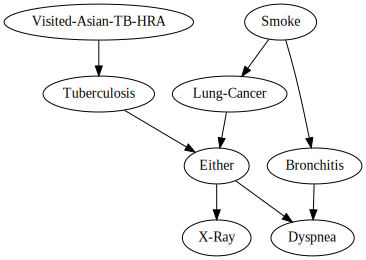

In [11]:
Source(open(in_dot).read())

# Learned Network Structures
## MB based learning
### Grow Shink
#### Qfog

In [12]:
%%capture qfog_gs_time
alpha = 8/len(states_df.index)
%time lnr = MB_GrowShrinkLner(states_df, alpha, verbose=False)

In [13]:
print(qfog_gs_time)

CPU times: user 1.44 s, sys: 12.3 ms, total: 1.45 s
Wall time: 1.45 s



In [14]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

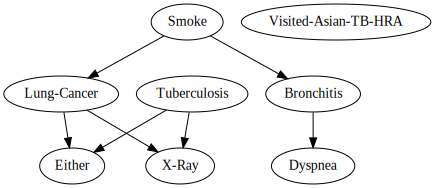

In [15]:
Source(open(learned_dot).read())

#### bnlearn

In [16]:
%%capture bnlearn_gs_time
%time %R bn <- gs(states_df);

In [17]:
print(bnlearn_gs_time)

CPU times: user 29.3 ms, sys: 8.03 ms, total: 37.3 ms
Wall time: 37.5 ms



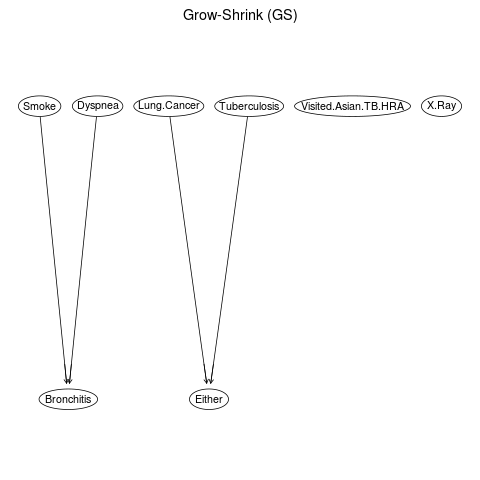

In [18]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Grow-Shrink (GS)");

### IAMB
#### QFog

In [19]:
%%capture qfog_iamb_time
alpha = 8/len(states_df.index)
%time lnr = MB_IAMB_Lner(states_df, alpha, verbose=False)

In [20]:
print(qfog_iamb_time)

CPU times: user 1.31 s, sys: 12 us, total: 1.31 s
Wall time: 1.31 s



In [21]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

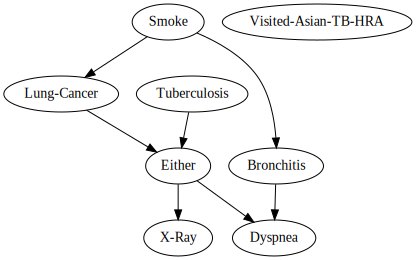

In [22]:
Source(open(learned_dot).read())

Results are sensitive to "alpha"

#### bnlearn

In [23]:
%%capture  bnlearn_iamb_time
%time %R bn <- iamb(states_df);

In [24]:
print(bnlearn_iamb_time)

CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 22.8 ms



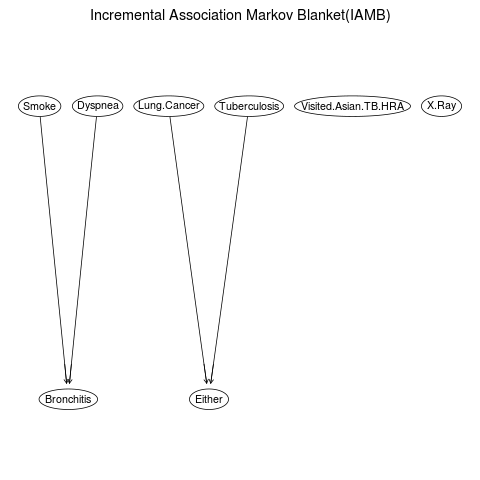

In [25]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Incremental Association Markov Blanket(IAMB)");

## Score based learning
### Hiil Climbing with BIC score
#### QFog

In [26]:
%%capture qfog_hc_bic_time
score_type = 'BIC'
max_num_mtries = 30
ess = 1.0 
%time lnr = HillClimbingLner(states_df, score_type, max_num_mtries, ess)

In [27]:
print(qfog_hc_bic_time)

CPU times: user 1.77 s, sys: 236 us, total: 1.77 s
Wall time: 1.77 s



In [28]:
lnr.bnet.write_dot(learned_dot) # write BNet to .dot file

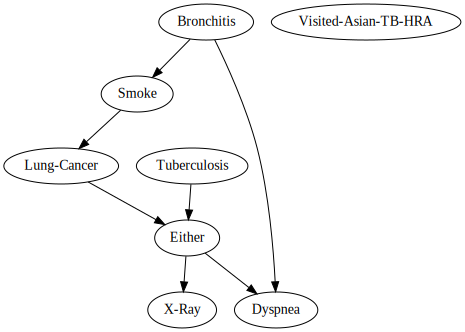

In [29]:
Source(open(learned_dot).read())

#### bnlearn

In bnlearn, the default score is **BIC** (Bayesian Information Criterion) for both discrete and continuous data sets

In [30]:
%%capture bnlearn_hc_bic_time
%time %R bn <- hc(states_df);

In [31]:
print(bnlearn_hc_bic_time)

CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 23.5 ms



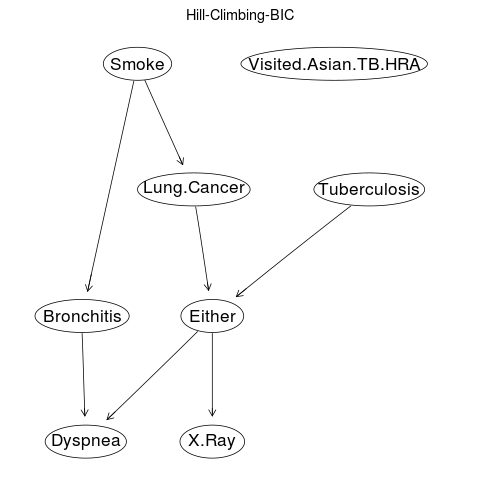

In [32]:
%R par(mfrow = c(1,1))
%R graphviz.plot(bn, shape = "ellipse", main = "Hill-Climbing-BIC");

## Summary of Running Times

In [33]:
%%bash
rm -f examples_cbnets/tempo.dot

In [34]:
print("-------------Grow-Shrink:")
print("QFog:", qfog_gs_time)
print("bnlearn:", bnlearn_gs_time)

print("-------------IAMB")
print("QFog:", qfog_iamb_time)
print("bnlearn:", bnlearn_iamb_time)

print("-------------Hill Climbing with BIC score:")
print("QFog:", qfog_hc_bic_time)
print("bnlearn:", bnlearn_hc_bic_time)

-------------Grow-Shrink:
QFog: CPU times: user 1.44 s, sys: 12.3 ms, total: 1.45 s
Wall time: 1.45 s

bnlearn: CPU times: user 29.3 ms, sys: 8.03 ms, total: 37.3 ms
Wall time: 37.5 ms

-------------IAMB


QFog: CPU times: user 1.31 s, sys: 12 us, total: 1.31 s
Wall time: 1.31 s

bnlearn: CPU times: user 22.3 ms, sys: 0 ns, total: 22.3 ms
Wall time: 22.8 ms

-------------Hill Climbing with BIC score:
QFog: CPU times: user 1.77 s, sys: 236 us, total: 1.77 s
Wall time: 1.77 s

bnlearn: CPU times: user 23.3 ms, sys: 0 ns, total: 23.3 ms
Wall time: 23.5 ms

